In [287]:
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score, recall_score, f1_score, r2_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from numpy.testing import assert_almost_equal
from sklearn.metrics import make_scorer
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression

In [288]:
df = pd.read_csv('insurance.csv')

In [289]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Which gender is prone to higher than averages charges?

In [290]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [291]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


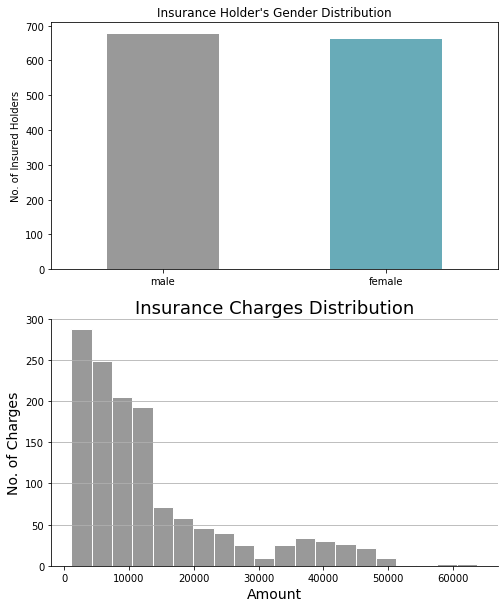

In [292]:
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(2,1,1)

ax = df['sex'].value_counts().plot(figsize=(8, 10), kind='bar', color=['#999999', '#68abb8'], width=0.5)

ax.set_xticklabels(['male', 'female'], rotation=0)
ax.set_title('Insurance Holder\'s Gender Distribution')
ax.set_ylabel('No. of Insured Holders');

ax2 = fig.add_subplot(2,1,2)

df['charges'].hist(ax=ax2, bins=20, edgecolor='w', color='#999999')
ax2.set_title('Insurance Charges Distribution', fontsize=18)
ax2.set_xlabel('Amount', fontsize=14)
ax2.set_ylabel('No. of Charges', fontsize=14)
ax2.set_ylim([0, 300]) 
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.xaxis.grid(False)
fig.savefig("figures/gender_and_charges_distribution.png")


/opt/python/3.10.4/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


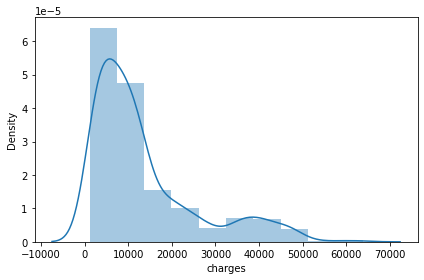

In [293]:
sns.distplot(df['charges'], bins=10)
plt.tight_layout()
plt.show()

In [294]:
features = df.columns

In [295]:
features

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [296]:
categorical_features = ['region']
categorical_features

['region']

In [297]:
enc = OneHotEncoder(handle_unknown='ignore')
res = enc.fit_transform(df[categorical_features])
res_df = pd.DataFrame(res.todense(), columns=enc.get_feature_names())

df.drop(categorical_features, axis=1, inplace=True)
df = pd.concat([df, res_df], axis=1)

df.head()

/opt/python/3.10.4/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,age,sex,bmi,children,smoker,charges,x0_northeast,x0_northwest,x0_southeast,x0_southwest
0,19,female,27.900,0,yes,16884.92400,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,1725.55230,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,4449.46200,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,21984.47061,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,3866.85520,0.0,1.0,0.0,0.0


In [298]:
# print(df['x0_female'].value_counts())
# print(df['x0_male'].value_counts())

In [299]:
X = df.drop(labels=['sex'], axis=1)
y = df['sex']

In [300]:
undersampler = RandomUnderSampler(sampling_strategy=1)
X_under, y_under = undersampler.fit_resample(X, y)

print(f"# of data points before resampling {len(y)}")
print(f"# of data points after resampling {len(y_under)}")
print(f"target distribution before resampling {Counter(y)}")
print(f"target distribution after resampling {Counter(y_under)}")

# of data points before resampling 1338
# of data points after resampling 1324
target distribution before resampling Counter({'male': 676, 'female': 662})
target distribution after resampling Counter({'female': 662, 'male': 662})


In [301]:
# from imblearn.over_sampling import SMOTE

# oversampler = SMOTE(sampling_strategy=1, k_neighbors=6)
# X_over, y_over = oversampler.fit_resample(X, y)

# print(f"# of data points before resampling {len(y)}")
# print(f"# of data points after resampling {len(y_over)}")
# print(f"target distribution before resampling {Counter(y)}")
# print(f"target distribution after resampling {Counter(y_over)}")

In [302]:
X_under.count()

age             1324
bmi             1324
children        1324
smoker          1324
charges         1324
x0_northeast    1324
x0_northwest    1324
x0_southeast    1324
x0_southwest    1324
dtype: int64

In [303]:
y_under

0       female
1       female
2       female
3       female
4       female
         ...  
1319      male
1320      male
1321      male
1322      male
1323      male
Name: sex, Length: 1324, dtype: object

In [304]:
X_under.head()

,age,bmi,children,smoker,charges,x0_northeast,x0_northwest,x0_southeast,x0_southwest
0,19,27.90,0,yes,16884.92400,0.0,0.0,0.0,1.0
1,31,25.74,0,no,3756.62160,0.0,0.0,1.0,0.0
2,46,33.44,1,no,8240.58960,0.0,0.0,1.0,0.0
3,37,27.74,3,no,7281.50560,0.0,1.0,0.0,0.0
4,60,25.84,0,no,28923.13692,0.0,1.0,0.0,0.0


In [305]:
df_gender = pd.DataFrame(y_under)

In [306]:
df_gender.head()

,sex
0,female
1,female
2,female
3,female
4,female


In [307]:
model_data = pd.merge(X_under, df_gender, left_index=True, right_index=True)

In [308]:
model_data

,age,bmi,children,smoker,charges,x0_northeast,x0_northwest,x0_southeast,x0_southwest,sex
0,19,27.900,0,yes,16884.92400,0.0,0.0,0.0,1.0,female
1,31,25.740,0,no,3756.62160,0.0,0.0,1.0,0.0,female
2,46,33.440,1,no,8240.58960,0.0,0.0,1.0,0.0,female
3,37,27.740,3,no,7281.50560,0.0,1.0,0.0,0.0,female
4,60,25.840,0,no,28923.13692,0.0,1.0,0.0,0.0,female
...,...,...,...,...,...,...,...,...,...,...
1319,59,41.140,1,yes,48970.24760,0.0,0.0,1.0,0.0,male
1320,21,35.530,0,no,1532.46970,0.0,0.0,1.0,0.0,male
1321,19,25.175,0,no,1632.03625,0.0,1.0,0.0,0.0,male
1322,44,37.100,2,no,7740.33700,0.0,0.0,0.0,1.0,male


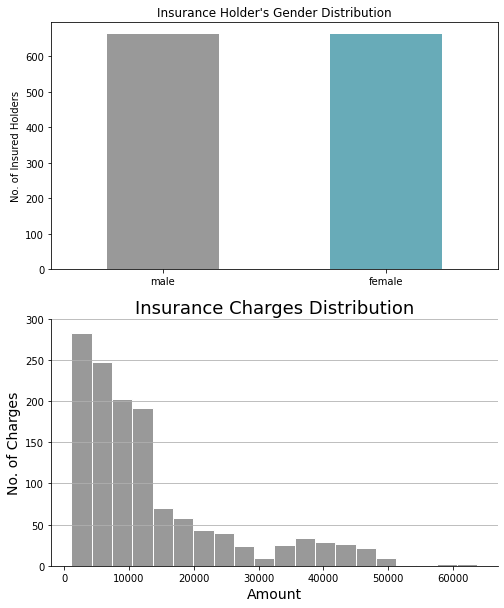

In [309]:
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(2,1,1)

ax = model_data['sex'].value_counts().plot(figsize=(8, 10), kind='bar', color=['#999999', '#68abb8'], width=0.5)

ax.set_xticklabels(['male', 'female'], rotation=0)
ax.set_title('Insurance Holder\'s Gender Distribution')
ax.set_ylabel('No. of Insured Holders');

ax2 = fig.add_subplot(2,1,2)

model_data['charges'].hist(ax=ax2, bins=20, edgecolor='w', color='#999999')
ax2.set_title('Insurance Charges Distribution', fontsize=18)
ax2.set_xlabel('Amount', fontsize=14)
ax2.set_ylabel('No. of Charges', fontsize=14)
ax2.set_ylim([0, 300]) 
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.xaxis.grid(False)
fig.savefig("figures/new_gender_and_charges_distribution.png")

In [310]:
gender_and_charges = model_data[['sex', 'charges']]

In [311]:
gender_and_charges.head()

,sex,charges
0,female,16884.92400
1,female,3756.62160
2,female,8240.58960
3,female,7281.50560
4,female,28923.13692


In [312]:
gender_and_charges["charges"].mean()

13276.994792635196

In [313]:
high_charges_and_gender = gender_and_charges.loc[gender_and_charges['charges'] >= gender_and_charges["charges"].mean()]

In [314]:
high_charges_and_gender.head()

,sex,charges
0,female,16884.92400
4,female,28923.13692
5,female,27808.72510
10,female,37701.87680
11,female,14001.13380


In [315]:
high_charges_and_gender.tail()

,sex,charges
1302,male,17361.76610
1308,male,39125.33225
1311,male,42124.51530
1317,male,37607.52770
1319,male,48970.24760


In [316]:
high_charges_and_gender.groupby("sex").sum().style.format("{:.1f}")

,charges
sex,
female,5154331.8
male,6373607.8


``It can be deduced that the male insurance holder are prone to higher insurance charges due to their approximately 1 million higher in charges compared with the female insurance holders``

``The insurance company should research on why males are often a riskier customer``

``For the preprocessing, the model data was undersampled to account for the 676 male entries as compared with 662 for the female entries. Since there are no missing data or nulls, data imputation is not necessary.``

In [317]:
categorical_features = ['sex']
categorical_features

['sex']

In [318]:
enc = OneHotEncoder(handle_unknown='ignore')
res = enc.fit_transform(model_data[categorical_features])
res_df = pd.DataFrame(res.todense(), columns=enc.get_feature_names())

model_data.drop(categorical_features, axis=1, inplace=True)
model_data = pd.concat([model_data, res_df], axis=1)

/opt/python/3.10.4/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [319]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           1324 non-null   int64  
 1   bmi           1324 non-null   float64
 2   children      1324 non-null   int64  
 3   smoker        1324 non-null   object 
 4   charges       1324 non-null   float64
 5   x0_northeast  1324 non-null   float64
 6   x0_northwest  1324 non-null   float64
 7   x0_southeast  1324 non-null   float64
 8   x0_southwest  1324 non-null   float64
 9   x0_female     1324 non-null   float64
 10  x0_male       1324 non-null   float64
dtypes: float64(8), int64(2), object(1)
memory usage: 113.9+ KB


In [320]:
model_data.smoker = model_data.smoker.map(dict(yes=1, no=0))

In [321]:
model_data.head()

,age,bmi,children,smoker,charges,x0_northeast,x0_northwest,x0_southeast,x0_southwest,x0_female,x0_male
0,19,27.90,0,1,16884.92400,0.0,0.0,0.0,1.0,1.0,0.0
1,31,25.74,0,0,3756.62160,0.0,0.0,1.0,0.0,1.0,0.0
2,46,33.44,1,0,8240.58960,0.0,0.0,1.0,0.0,1.0,0.0
3,37,27.74,3,0,7281.50560,0.0,1.0,0.0,0.0,1.0,0.0
4,60,25.84,0,0,28923.13692,0.0,1.0,0.0,0.0,1.0,0.0


In [322]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           1324 non-null   int64  
 1   bmi           1324 non-null   float64
 2   children      1324 non-null   int64  
 3   smoker        1324 non-null   int64  
 4   charges       1324 non-null   float64
 5   x0_northeast  1324 non-null   float64
 6   x0_northwest  1324 non-null   float64
 7   x0_southeast  1324 non-null   float64
 8   x0_southwest  1324 non-null   float64
 9   x0_female     1324 non-null   float64
 10  x0_male       1324 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 113.9 KB


In [334]:
model_data = round(model_data).astype(int)

In [335]:
model_data.head()

,age,bmi,children,smoker,charges,x0_northeast,x0_northwest,x0_southeast,x0_southwest,x0_female,x0_male,rounded_bmi
0,19,28,0,1,16885,0,0,0,1,1,0,28
1,31,26,0,0,3757,0,0,1,0,1,0,26
2,46,33,1,0,8241,0,0,1,0,1,0,33
3,37,28,3,0,7282,0,1,0,0,1,0,28
4,60,26,0,0,28923,0,1,0,0,1,0,26


In [336]:
X = model_data.drop(labels=['charges', 'bmi'], axis=1)
y = model_data['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [357]:
estimator = LogisticRegression(solver='saga', max_iter=10000)
selector = RFE(estimator, n_features_to_select=6, step=0.3)
selector.fit(X_train, y_train)

RFE(estimator=LogisticRegression(max_iter=10000, solver='saga'),
    n_features_to_select=6, step=0.3)

In [358]:
X_train.columns[selector.get_support()]

Index(['age', 'children', 'x0_northwest', 'x0_female', 'x0_male',
       'rounded_bmi'],
      dtype='object')

In [353]:
X_train.value_counts('x0_northeast')

x0_northeast
0    800
1    259
dtype: int64

In [354]:
X_train.value_counts('x0_northwest')

x0_northwest
0    796
1    263
dtype: int64

In [355]:
X_train.value_counts('x0_southeast')

x0_southeast
0    775
1    284
dtype: int64

In [356]:
X_train.value_counts('x0_southwest')

x0_southwest
0    806
1    253
dtype: int64